In [1]:
# from IPython.display import HTML, Image
# HTML('''
#     <script src='https://ajax.googleapis.com/ajax/libs/jquery/3.6.1/jquery.min.js'></script>
#     <script>
#     code_show=false;
#     function code_toggle() {
#         if (code_show){
#         $('div.jp-Editor').show();
#         } else {
#         $('div.jp-Editor').hide();
#     }
#         code_show = !code_show
#     }
#     $( document ).ready(code_toggle);
#     </script>
#     <form action='javascript:code_toggle()'><input type='submit' value='Click here to toggle on/off the raw code.'></form>''')


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('style/advocate.mplstyle')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

The imported file is the Excel spreadsheet provided by the state on 11/28/2022. In excel, the format of all columns containing floats was changed to eliminate commas and the file was saved as CSV.

In [3]:
rh = pd.read_csv('raw data/Road Home Closed with Jurisdiction Census Info 7-19-2022 with ARS.csv', dtype='str')

float_fields =    ['Closing Option', 
                    'TOTAL_CLOSING_AMOUNT',
                    'Total CG Amount',
                    'Total ACG Amunt',
                    'Total Elevation Amount',
                    'Total IMM Amount',
                    'Current Damage Assessment',
                    'Current Damage Assessment - Type 1',
                    'Current Damage Assessment - Type 2',
                    'Damage Type 1 or 2',
                    'Current PSV',
                    'Current Total DOB Amount (no Legal Fees removed)',
                    'Current Legal Fees',
                    'Closing Damage Assessment',
                    'PSV at Closing',
                    'Closing Total DOB Amount',
                    'Difference between Current PSV and Current Damage Assessment Type 2 (col AG - col AC'
                    ]
for field in float_fields:
    rh[field] = rh[field].astype('float64')


In [4]:
# Exclude the row that includes the sum for each field
rh = rh[rh['Census Block'].notnull()]

In [5]:
rh.columns

Index(['Structure Type', 'GIS City', 'GIS State', 'GIS Zip', 'PARISH',
       'Closing Option', 'TOTAL_CLOSING_AMOUNT', 'Total CG Amount',
       'Total ACG Amunt', 'Total Elevation Amount', 'Total IMM Amount',
       'NOLA Planning District Number', 'NOLA Planning District Name',
       'NOLA Neighborhood Number', 'NOLA Neighborhood Name', 'STFID',
       'Census Block', 'Block Group', 'Census Track', 'ORL_CD_NUM',
       'ORL_CD_NAM', 'Current Damage Assessment',
       'Current Damage Assessment - Type 1',
       'Current Damage Assessment - Type 2', 'Damage Type 1 or 2',
       'Current PSV', 'Current Total DOB Amount (no Legal Fees removed)',
       'Current Legal Fees', 'Closing Damage Assessment', 'PSV at Closing',
       'Closed file - PSV Option 1 With No ACG -excluding Sold Home, Inelig, Deceased and files closed with RHEI & IMM only -23,912',
       'Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only',
       'Closed with Approved Un

In [6]:
print('Basic stats:')
print(f"Number of records: {len(rh):,.0f}")
print(f"Number of non-null records: {len(rh.dropna(axis=1)):,.0f}")
print(f"Number of records where CG>0 and DA>0: {len(rh[(rh['Current Damage Assessment']>0) & (rh['Total CG Amount']>0)]):,.0f}")
print(f"Total grant amount: ${rh['TOTAL_CLOSING_AMOUNT'].sum():,.2f}")
print(f"Total damage assessment: ${rh['Current Damage Assessment'].sum():,.2f}")
print(f"Total CG amount: ${rh['Total CG Amount'].sum():,.2f}")
print(f"Total ACG amount: ${rh['Total ACG Amunt'].sum():,.2f}")
print(f"Total elevation amount: ${rh['Total Elevation Amount'].sum():,.2f}")
print(f"Total IMM amount: ${rh['Total IMM Amount'].sum():,.2f}")
print(f"Total DOB amount: ${rh['Current Total DOB Amount (no Legal Fees removed)'].sum():,.2f}")
print(f"Total legal fees: ${rh['Current Legal Fees'].sum():,.2f}")


Basic stats:
Number of records: 130,053
Number of non-null records: 130,053
Number of records where CG>0 and DA>0: 122,668
Total grant amount: $9,030,446,583.33
Total damage assessment: $18,313,314,464.07
Total CG amount: $5,767,978,729.72
Total ACG amount: $2,126,950,433.45
Total elevation amount: $942,775,529.66
Total IMM amount: $192,741,890.50
Total DOB amount: $6,026,881,082.18
Total legal fees: $38,267,095.46


In [7]:
pipeline = pd.DataFrame(index=['Calcasieu', 'Jefferson', 'Orleans', 'St. Bernard', 'St. Tammany'], columns=['Pipeline Option 1 count'], data=[12717, 25128, 41638, 7848, 10939])
print('Comparison of dataset and pipeline Option 1 counts for top 5 parishes by number of properties that participated in Road Home')
dataset_pipeline_compare = pd.concat([
                                        rh[
                                            (rh['PARISH'].isin(['Orleans', 'Jefferson', 'Calcasieu', 'St. Tammany', 'St. Bernard'])) & 
                                            (rh['Closing Option']==1)
                                            ]
                                            .groupby('PARISH')
                                            .agg(
                                                {
                                                    'Total CG Amount' : 'count', 
                                                    }
                                                )
                                            .rename(columns = {'Total CG Amount' : 'Dataset Option 1 count'})
                                        ,
                                        pipeline
                                        ],
                                        axis=1
                                    )
dataset_pipeline_compare['Difference'] = dataset_pipeline_compare['Dataset Option 1 count']-dataset_pipeline_compare['Pipeline Option 1 count']
display(dataset_pipeline_compare)

Comparison of dataset and pipeline Option 1 counts for top 5 parishes by number of properties that participated in Road Home


,Dataset Option 1 count,Pipeline Option 1 count,Difference
Calcasieu,12702,12717,-15
Jefferson,25148,25128,20
Orleans,41614,41638,-24
St. Bernard,7852,7848,4
St. Tammany,10944,10939,5


Setting up rh_clean, which will exclude records from the analysis. The criteria for inclusion are:
- rh['Current Damage Assessment']>0 : Exclude records with no recorded damage. This excludes properties that did not have damage recorded.
- rh['Total CG Amount']>0 : Exclude records with no Compensation Grants. This excludes properties that may have damage recorded but did not get repair/rebuilding grants.
- rh['Closing Option']==1 : Exclude any properties whose owners chose Option 2 (sell property to the state and buy another home in Louisiana) and Option 3 (sell property to the state and do not buy a home in Louisiana).
- rh['Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only']=='N' : This flag was created by the state. This includes the three criteria listed above as well as edge cases that might skew the data. Earlier criteria are included to ensure all matching properties are excluded.
- rh['Closed with Unmet Needs (Y/N)']=='N' : Exclude properties that got money through the Unmet Needs program. These properties received additional money from the state for problems outside of their control (such as contractors taking money but not doing work). The state did not provide specific Unmet Needs amounts, so these properties must be excluded entirely. 
- rh['ARS File (Yes/No)=='N'] : Exclude properties that are subject to a lawsuit between the state and its contractor (ICF) over incorrect grant values


In [8]:
rh_clean = rh[
    (rh['Current Damage Assessment']>0) & 
    (rh['Total CG Amount']>0) & 
    (rh['Closing Option']==1) &
    (rh['Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only']=='N') &
    (rh['Closed with Approved Unmet Needs (Y/N)']=='N') &
    (rh['ARS File (Yes/No)']=='N')
    ].copy()

In [9]:
print('Basic stats (with non-relevant records excluded):')
print(f"Number of records: {len(rh_clean):,.0f}")
print(f"Number of non-null records: {len(rh_clean.dropna(axis=1)):,.0f}")
print(f"Number of records where CG>0 and DA>0: {len(rh_clean[(rh_clean['Current Damage Assessment']>0) & (rh_clean['Total CG Amount']>0)]):,.0f}")
print(f"Total damage assessment: ${rh_clean['Current Damage Assessment'].sum():,.2f}")
print(f"Total grant amount: ${rh_clean['TOTAL_CLOSING_AMOUNT'].sum():,.2f}")
print(f"Total CG amount: ${rh_clean['Total CG Amount'].sum():,.2f}")
print(f"Total ACG amount: ${rh_clean['Total ACG Amunt'].sum():,.2f}")
print(f"Total elevation amount: ${rh_clean['Total Elevation Amount'].sum():,.2f}")
print(f"Total IMM amount: ${rh_clean['Total IMM Amount'].sum():,.2f}")
print(f"Total DOB amount: ${rh_clean['Current Total DOB Amount (no Legal Fees removed)'].sum():,.2f}")
print(f"Total legal fees: ${rh_clean['Current Legal Fees'].sum():,.2f}")


Basic stats (with non-relevant records excluded):
Number of records: 93,490
Number of non-null records: 93,490
Number of records where CG>0 and DA>0: 93,490
Total damage assessment: $12,378,566,488.50
Total grant amount: $6,438,287,932.89
Total CG amount: $4,127,228,647.02
Total ACG amount: $1,517,663,016.58
Total elevation amount: $636,665,696.75
Total IMM amount: $156,730,572.54
Total DOB amount: $3,910,966,433.69
Total legal fees: $26,839,981.72


In some cases, the DOB amount increased after the initial grants were awarded. In those cases, the combined CG/ACG amount in these records was not adjusted to reflect the increase. However, the state sought to claw back the money from CG/ACG, which now represents an overpayment.

As a result, we have to adjust the combined CG/ACG values so they reflect the appropriate amount actually provided to the property owner.

In [10]:
rh_clean['Current DOB (no legal fees)'] = rh_clean['Current Total DOB Amount (no Legal Fees removed)'].fillna(0.0)-rh_clean['Current Legal Fees'].fillna(0.0)

rh_clean['dob_difference'] = rh_clean['Current DOB (no legal fees)'] - rh_clean['Closing Total DOB Amount']
print(f"DOB increase : {len(rh_clean[rh_clean['dob_difference']>0]):,.0f}")
print(f"DOB decrease : {len(rh_clean[rh_clean['dob_difference']<0]):,.0f}")

DOB increase : 12,819
DOB decrease : 14,105


According to Jeff Haley, DOB could be adjusted up or down through the process. A DOB decrease, however, would already be accounted for in the Current DOB figure and the Current CG/ACG figures. So we want to only subtract adjustments where DOB increased (in other words, where dob_difference>0).

Subtracting values from CG. A version of this analysis with the DOB Increases subtracted from ACG yields almost identical results.

In [11]:
rh_clean.loc[rh_clean['dob_difference']>0, 'Total CG Amount'] = rh_clean['Total CG Amount']-rh_clean['dob_difference']

In [12]:
rh_clean['compensation'] = rh_clean['Total CG Amount'].fillna(0.0)+rh_clean['Total ACG Amunt'].fillna(0.0)+rh_clean['Current DOB (no legal fees)'].fillna(0.0)

In [13]:
rh_clean[(rh_clean['compensation']==rh_clean['Current Damage Assessment'])][['Census Block', 'Total CG Amount', 'Total ACG Amunt', 'compensation', 'Current Damage Assessment', 'Closing Damage Assessment', 'Current Total DOB Amount (no Legal Fees removed)', 'Closing Total DOB Amount']]

,Census Block,Total CG Amount,Total ACG Amunt,compensation,Current Damage Assessment,Closing Damage Assessment,Current Total DOB Amount (no Legal Fees removed),Closing Total DOB Amount
6,220710081021016,"11,392.28",0.00,"66,370.80","66,370.80","66,370.80","54,978.52","54,978.52"
8,220710121012015,"65,536.32",0.00,"94,533.80","94,533.80","94,533.80","28,997.48","29,483.26"
16,220510208002007,"7,905.23",0.00,"17,545.14","17,545.14","17,545.14","9,639.91","9,639.91"
17,220510234003008,"19,087.22",0.00,"36,751.91","36,751.91","36,751.91","17,664.69","17,664.69"
19,220710006041005,"30,408.52",0.00,"51,723.71","51,723.71","21,667.22","21,315.19","25,780.19"
...,...,...,...,...,...,...,...,...
130046,220710017401003,"9,193.44",0.00,"155,280.46","155,280.46","155,280.46","146,087.02","146,087.02"
130047,220550019011007,"8,151.26","32,098.74","40,250.00","40,250.00","40,250.00",0.00,0.00
130049,221059547001048,"5,856.87",0.00,"12,616.80","12,616.80","11,984.70","6,759.93","6,759.93"
130050,221059548003006,"12,488.28","31,255.35","45,850.00","45,850.00","45,850.00","2,106.37","2,106.37"


In [14]:
rh_clean[(rh_clean['compensation']>rh_clean['Current Damage Assessment'])]

,Structure Type,GIS City,GIS State,GIS Zip,PARISH,Closing Option,TOTAL_CLOSING_AMOUNT,Total CG Amount,Total ACG Amunt,Total Elevation Amount,Total IMM Amount,NOLA Planning District Number,NOLA Planning District Name,NOLA Neighborhood Number,NOLA Neighborhood Name,STFID,Census Block,Block Group,Census Track,ORL_CD_NUM,ORL_CD_NAM,Current Damage Assessment,Current Damage Assessment - Type 1,Current Damage Assessment - Type 2,Damage Type 1 or 2,Current PSV,Current Total DOB Amount (no Legal Fees removed),Current Legal Fees,Closing Damage Assessment,PSV at Closing,"Closed file - PSV Option 1 With No ACG -excluding Sold Home, Inelig, Deceased and files closed with RHEI & IMM only -23,912","Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only",Closed with Approved Unmet Needs (Y/N),Applicant With Current Insurance (Private and/or Flood) Y/N,Closing Total DOB Amount,Difference between Current PSV and Current Damage Assessment Type 2 (col AG - col AC,ARS File (Yes/No),Current DOB (no legal fees),dob_difference,compensation
7,Single (including mobile home),HARVEY,LA,70058-5411,Jefferson,1.00,"6,358.26","6,358.26",0.00,0.00,0.00,NaN,NaN,NaN,NaN,220510278052010,220510278052010,220510278052,22051027805,NaN,NaN,"27,263.19","302,889.00","27,263.19",2.00,"138,000.00","20,904.93",0.00,"27,263.19","138,000.00",N,N,N,Y,"20,904.93","-110,736.81",N,"20,904.93",0.00,"27,263.19"
10,Single (including mobile home),METAIRIE,LA,70005-4008,Jefferson,1.00,"41,715.80","29,571.80",0.00,0.00,"7,500.00",NaN,NaN,NaN,NaN,220510226001005,220510226001005,220510226001,22051022600,NaN,NaN,"60,369.21","661,041.60","60,369.21",2.00,"748,000.00","35,446.41","4,649.00","60,369.21","748,000.00",N,N,N,Y,"26,153.41","-687,630.79",N,"30,797.41","4,644.00","60,369.21"
11,Single (including mobile home),AVONDALE,LA,70094-2423,Jefferson,1.00,"38,906.51","21,984.56","9,421.95",0.00,"7,500.00",NaN,NaN,NaN,NaN,220510275025004,220510275025004,220510275025,22051027502,NaN,NaN,"31,406.51","106,800.00","31,406.51",2.00,"98,000.00",0.00,0.00,"31,406.51","98,000.00",N,N,N,N,"8,414.42","-66,593.49",N,0.00,"-8,414.42","31,406.51"
75,Single (including mobile home),METAIRIE,LA,70006-3919,Jefferson,1.00,"12,240.60","12,240.60",0.00,0.00,0.00,NaN,NaN,NaN,NaN,220510217006003,220510217006003,220510217006,22051021700,NaN,NaN,"72,944.40","240,832.20","72,944.40",2.00,"210,000.00","60,703.80",0.00,"72,944.40","175,000.00",N,N,N,Y,"66,387.58","-137,055.60",N,"60,703.80","-5,683.78","72,944.40"
99,Single (including mobile home),METAIRIE,LA,70003-2107,Jefferson,1.00,"10,224.08","10,224.08",0.00,0.00,0.00,NaN,NaN,NaN,NaN,220510234001020,220510234001020,220510234001,22051023400,NaN,NaN,"99,495.54","270,269.40","99,495.54",2.00,"198,000.00","89,271.46",0.00,"99,495.54","198,000.00",N,N,N,Y,"89,271.46","-98,504.46",N,"89,271.46",0.00,"99,495.54"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129982,Duplex (with one owner-occupied unit),NEW ORLEANS,LA,70119-1332,Orleans,1.00,"70,325.90","49,207.13","21,118.77",0.00,0.00,4,Mid-City,14,Seventh Ward,220710030001000,220710030001000,220710030001,22071003000,NaN,NaN,"110,295.90","266,026.20","110,295.90",2.00,"128,000.00","40,000.00",0.00,"110,295.90","128,000.00",N,N,N,Y,"40,000.00","-17,704.10",N,"40,000.00",0.00,"110,325.90"
129996,Single (including mobile home),NEW ORLEANS,LA,70131-8319,Orleans,1.00,"12,475.63","4,975.63",0.00,0.00,"7,500.00",12,Algiers,9,Tall Timbers/Brechtel,220710006142007,220710006142007,220710006142,22071000614,NaN,NaN,"18,472.42","499,667.40","18,472.42",2.00,"175,000.00","13,496.79",0.00,"18,472.42","175,000.00",N,N,N,Y,"13,496.79","-156,527.58",N,"13,496.79",0.00,"18,472.42"
129997,Single (including mobile home),SULPHUR,LA,70663-5072,Calcasieu,1.00,"109,313.93","50,679.26","28,634.67","30,000.00",0.00,NaN,NaN,NaN,NaN,220190030002005,220190030002005,220190030002,22019003000,NaN,

Filter out records where compensation is higher than damage

In [15]:
rh_clean = rh_clean[(rh_clean['compensation']<=rh_clean['Current Damage Assessment']+0.000001)]


Aggregate rh_clean to blocks and rename fields to match names used in past analyses.

In [16]:
rh_blocks = (rh_clean
            .groupby('Census Block')
            .agg({
                'Closing Option' : 'count', 
                'TOTAL_CLOSING_AMOUNT' : 'sum', 
                'Total CG Amount' : 'sum',
                'Total ACG Amunt' : 'sum',
                'Total Elevation Amount' : 'sum',
                'Total IMM Amount' : 'sum',
                'Current Damage Assessment' : 'sum',
                'Current Damage Assessment - Type 1' : 'sum',
                'Current Damage Assessment - Type 2' : 'sum',
                'Current PSV' : 'sum',
                'Current DOB (no legal fees)' : 'sum'
                })
            )

rh_blocks = rh_blocks.reset_index().rename(columns = {
                    'Census Block' : 'GEOID',
                    'Total CG Amount' : 'compensation_sum',
                    'Total ACG Amunt' : 'additional_compensation_sum',
                    'Total Elevation Amount' : 'elevation_sum',
                    'Total IMM Amount' : 'mitigation_sum',
                    'TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
                    'Closing Option' : 'all_grants_count',
                    'Current PSV' : 'pre_storm_value_sum',
                    'Current Damage Assessment' : 'damage_sum',
                    'Current DOB (no legal fees)' : 'insurance_sum',
                    'Current Damage Assessment - Type 1' : 'damage_type_1',
                    'Current Damage Assessment - Type 2' : 'damage_type_2'

})
rh_blocks['GEOID'] = rh_blocks['GEOID'].astype(str)

Import block group-level IPUMS data on race, income and households. NOTE: These fields are required for the rest of the analysis

In [17]:
income = pd.read_csv('processed data/rh_block_groups_all_LA_income_poverty_race_table_3.csv')
income['GEOID'] = income['GEOID'].astype(str)
income = income.rename(columns=
                        {"HAK001": "total_pop",
                        "HA2001":"total_households",
                        "HAQ001": "not_hispanic",
                        "HAQ002": "hispanic",
                        "HAR001":"not_hispanic_white",
                        "HAR002":"not_hispanic_black",
                        "HAR003":"not_hispanic_native",
                        "HAR004":"not_hispanic_asian",
                        "HAR005":"not_hispanic_pacific_islander",
                        "HAR006":"not_hispanic_other",
                        "HAR007":"not_hispanic_two_or_more",
                        "HAR008":"hispanic_white",
                        "HAR009":"hispanic_black",
                        "HAR010":"hispanic_native",
                        "HAR011":"hispanic_asian",
                        "HAR012":"hispanic_pacific_islander",
                        "HAR013":"hispanic_other",
                        "HAR014":"hispanic_two_or_more",
                        "HF5001":"hh_lt_10000",
                        "HF5002":"hh_10000_14999",
                        "HF5003":"hh_15000_19999",
                        "HF5004":"hh_20000_24999",
                        "HF5005":"hh_25000_29999",
                        "HF5006":"hh_30000_34999",
                        "HF5007":"hh_35000_39999",
                        "HF5008":"hh_40000_44999",
                        "HF5009":"hh_45000_49999",
                        "HF5010":"hh_50000_59999",
                        "HF5011":"hh_60000_74999",
                        "HF5012":"hh_75000_99999",
                        "HF5013":"hh_100000_124999",
                        "HF5014":"hh_125000_149999",
                        "HF5015":"hh_150000_199999",
                        "HF5016":"hh_gte_200000",
                        "HF6001":"hh_median_income",
                        "HHE001":"persons_below_poverty_level",
                        "HHE002":"persons_at_or_below_poverty_level",
                        "HHS001":"hh_below_poverty_level",
                        "HHS002":"hh_at_or_below_poverty_level"}
                    )

Various operations to generate geographic identifiers and rename columns to prepare for block level aggregation.

In [18]:
# rh_all = (rh_blocks
#            .merge(flood_blocks, on='GEOID', how='outer')
#            .merge(blocks_race, on='GEOID', how='outer')
#            .merge(households, on='GEOID', how='outer'))


rh_all = rh_blocks.copy()
rh_all['CNTYIDFP00'] = rh_all['GEOID'].str[:5]
rh_all['BKGPIDFP00'] = rh_all['GEOID'].str[:12]
rh_all['TRACTIDFP00'] = rh_all['GEOID'].str[:11]

rh_all = rh_all.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }


)

agg_fields = [
    'compensation_sum',
    'additional_compensation_sum',
    'elevation_sum', 
    'mitigation_sum', 
    'all_grants_sum', 
    'all_grants_count',
    'pre_storm_value_sum', 
    'damage_sum', 
    'insurance_sum',
    # 'Total', 
    # 'White', 
    # 'Black', 
    # 'Hispanic', 
    # 'Indigenous', 
    # 'Asian', 
    # 'NHOPI',
    # 'Other', 
    # 'Multiracial',
    # 'households_2000_total',
    # 'households_2000_owner_occupied',
    # 'households_2000_owner_occupied_black',
]



This function generates a variety of fields that will be used for the analysis

In [19]:
def helper_fields(df):
    df['damage_mean'] = df['damage_sum'] / df['all_grants_count']
    df['grant_insurance_sum'] = df['compensation_sum']+df['additional_compensation_sum']+df['insurance_sum']
    df['grant_insurance_mean'] = df['grant_insurance_sum']/df['all_grants_count']
    df['cg_insurance_sum'] = df['compensation_sum']+df['insurance_sum']
    df['cg_insurance_mean'] = df['cg_insurance_sum']/df['all_grants_count']
    df['uncovered_sum'] = df['damage_sum'] - df['grant_insurance_sum']
    df['uncovered_mean'] = df['uncovered_sum']/df['all_grants_count']
    df['uncovered_percent'] = (df['damage_sum']-df['grant_insurance_sum'])/df['damage_sum']
    df['cg_uncovered_sum'] = df['damage_sum']-df['cg_insurance_sum']
    df['cg_uncovered_mean'] = df['cg_uncovered_sum']/df['all_grants_count']
    df['cg_uncovered_percent'] = df['cg_uncovered_sum']/df['damage_sum']
    df['pre_storm_value_mean'] = (df['pre_storm_value_sum']/df['all_grants_count'])
    # NOTE: white_percent is calculated using Table 3 IPUMS data
    df['white_percent'] = df['not_hispanic_white']/df['total_pop']
    # df['rh_household_pct'] = df['all_grants_count']/df['households_2000_owner_occupied']
    # df['households_2000_owner_occupied_pct'] = df['households_2000_owner_occupied']/df['households_2000_total']
    # df['households_2000_owner_occupied_black_pct'] = df['households_2000_owner_occupied_black']/df['households_2000_total']
    df['percent_poverty_status'] = df['hh_below_poverty_level']/df['total_households']
    # Buyouts are not yet part of this analysis. Still working on cleaning the St. Bernard geocoding.
    # df['buyouts_households_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']
    # df['buyouts_owner_occupied_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']

    return df

Aggregate at block group level, add block group demographic/income data and add helper fields and create income/poverty/race bins and quintiles

In [20]:

rh_bg_all = rh_all.groupby('BKGPIDFP00')[agg_fields].sum()
rh_bg_all = rh_bg_all.merge(income, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
rh_bg_all = helper_fields(rh_bg_all)
rh_bg_all['CNTYIDFP00'] = rh_bg_all['GEOID'].str[:5]
rh_bg_all['BKGPIDFP00'] = rh_bg_all['GEOID']

rh_bg_all['hh_median_income_bin'] = pd.cut(
    rh_bg_all[rh_bg_all['compensation_sum']>0]['hh_median_income'], 
    bins=[0,15000,30000,45000,60000,75000,200000])
rh_bg_all['hh_median_income_quint'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_o_stb'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22071']) & (rh_bg_all['compensation_sum']>0))]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22087'])) & (rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['percent_poverty_bins'] = pd.cut(rh_bg_all['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1], labels = ['Less than 20%', '20% to 40%', '40% to 60%', '60% to 80%', 'More than 80%'])
rh_bg_all['percent_poverty_quint'] = pd.qcut(rh_bg_all[rh_bg_all['compensation_sum']>0]['percent_poverty_status'], q=5)
rh_bg_all['percent_poverty_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
rh_bg_all['percent_poverty_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

rh_bg_all['white_percent_bins'] = pd.cut(rh_bg_all['white_percent'], bins=[0,.2,.4,.6,.8,1], labels = ['Less than 20%', '20% to 40%', '40% to 60%', '60% to 80%', 'More than 80%'])
rh_bg_all['white_percent_quint'] = pd.qcut(rh_bg_all[rh_bg_all['compensation_sum']>0]['white_percent'], q=5)
rh_bg_all['white_percent_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
rh_bg_all['white_percent_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')


Aggregate block groups on the neighborhood level

In [21]:
bg_neighborhood = pd.read_csv('processed data/block_groups_neighborhoods.csv')
bg_neighborhood['BKGPIDFP00'] = bg_neighborhood['BKGPIDFP00'].astype(str)
rh_bg_all = rh_bg_all.merge(bg_neighborhood, left_on='GEOID', right_on='BKGPIDFP00', how='outer')
rh_neighborhoods = rh_bg_all[rh_bg_all['NBHD'].notnull()][agg_fields+['total_pop', 'not_hispanic_white', 'hh_below_poverty_level', 'total_households', 'NBHD']].groupby('NBHD').sum()
rh_neighborhoods = helper_fields(rh_neighborhoods)
rh_neighborhoods_shp = gpd.read_file('shapefiles/neighborhoods/neighborhoods_orleans.shp')
rh_neighborhoods = rh_neighborhoods_shp.merge(rh_neighborhoods, on='NBHD', how='outer')

bg_shp = gpd.read_file('shapefiles/block_groups/orleans_stbernard_bg_no_water.shp')
rh_bg_all = bg_shp.merge(rh_bg_all, left_on='BKGPIDFP00', right_on='GEOID', how='outer')


# New Orleans neighborhood map

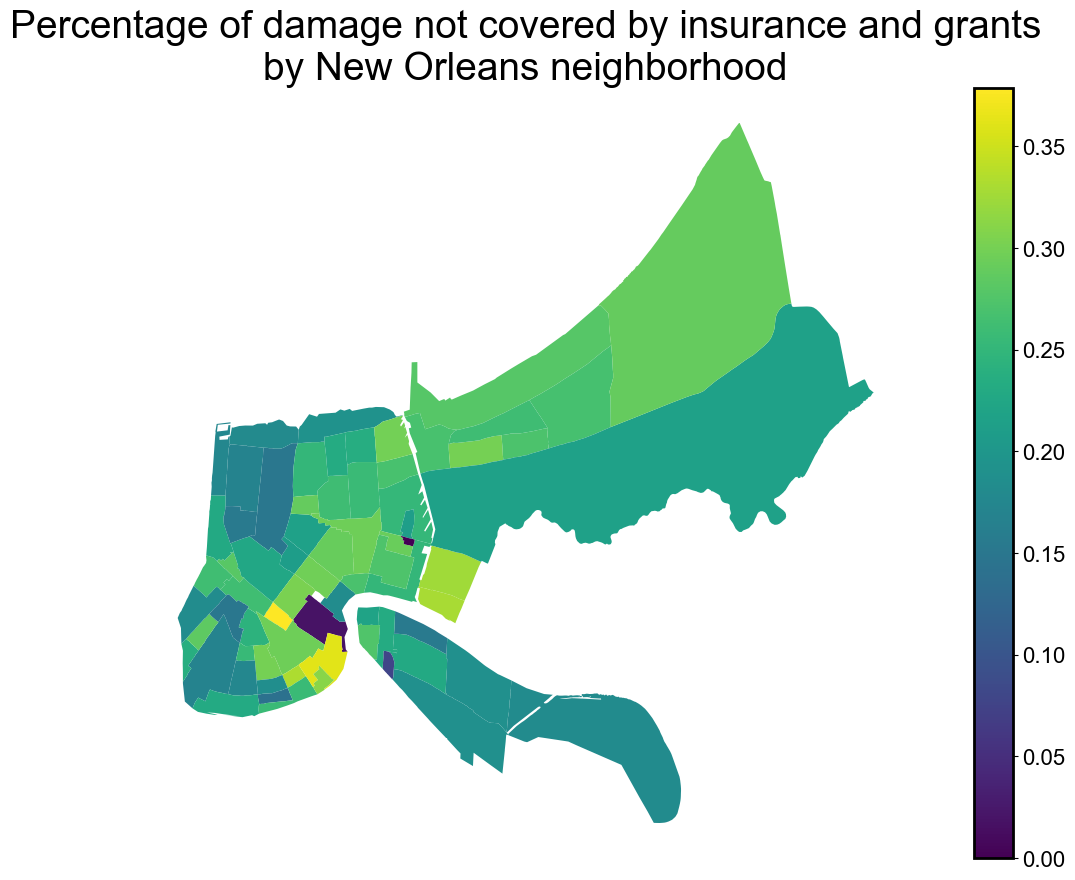

In [22]:
fig, ax = plt.subplots(figsize=(17,10))
rh_neighborhoods.plot(column='uncovered_percent', ax=ax, legend=True, cmap='viridis')
plt.title('Percentage of damage not covered by insurance and grants\nby New Orleans neighborhood')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

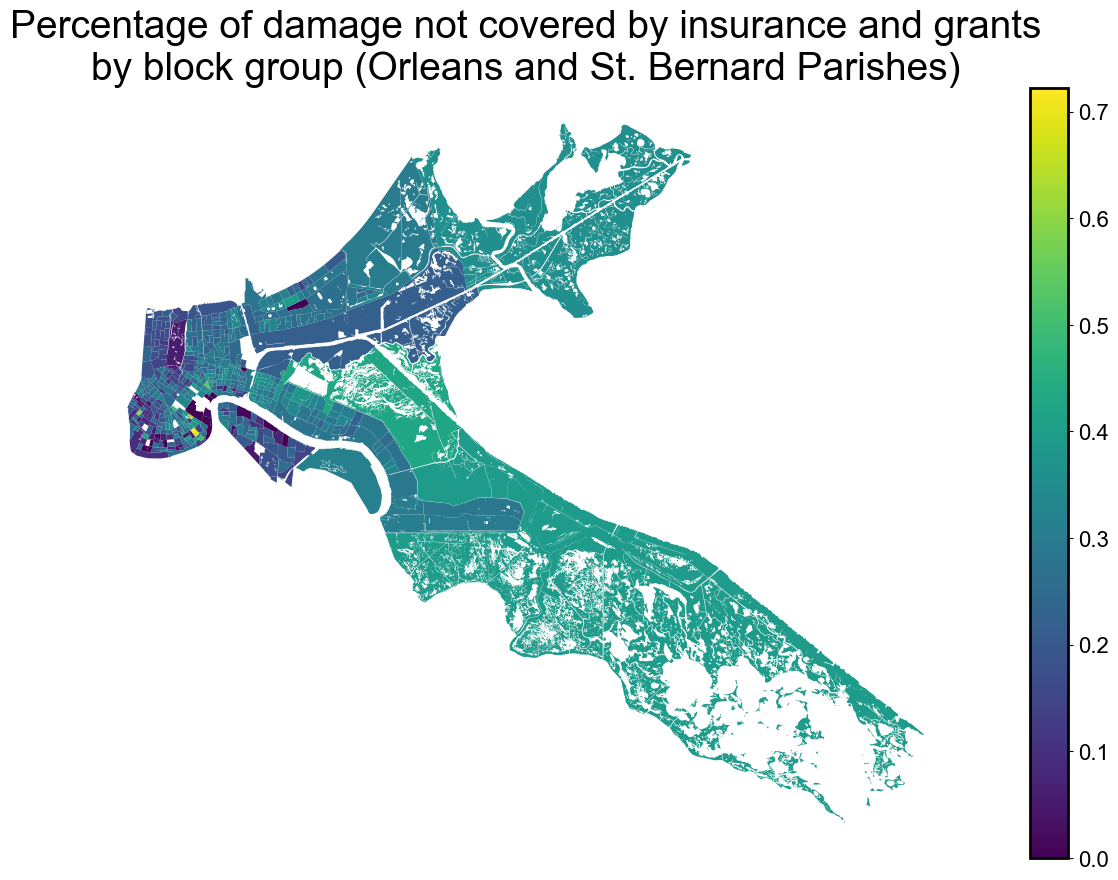

In [23]:
fig, ax = plt.subplots(figsize=(17,10))
rh_bg_all[rh_bg_all['CNTYIDFP00'].isin(['22071', '22087'])].plot(column='uncovered_percent', ax=ax, legend=True, cmap='viridis')
plt.title('Percentage of damage not covered by insurance and grants\nby block group (Orleans and St. Bernard Parishes)')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

Function to generate the bucket and quintile tables

In [24]:
def table_maker(df, grouping, title, parishes=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
        if parishes:
            print(title)
            display(pd.concat([
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'all_grants_count' : 'sum'}).squeeze().rename('Count of Road Home properties'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'all_grants_count' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Road Home properties'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'total_pop' : 'sum'}).squeeze().rename('Population'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'total_pop' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Population'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'BKGPIDFP00' : 'count'}).squeeze().rename('Count of Block Groups'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'BKGPIDFP00' : 'count'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Block Groups')

            ], axis=1))
        else:
            print(title)
            display(pd.concat([
                df.groupby(grouping).agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
                df.groupby(grouping).agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
                df.groupby(grouping).agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
                df.groupby(grouping).agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
                df.groupby(grouping).agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
                df.groupby(grouping).agg({'all_grants_count' : 'sum'}).squeeze().rename('Count of Road Home properties'),
                df.groupby(grouping).agg({'all_grants_count' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Road Home properties'),
                df.groupby(grouping).agg({'total_pop' : 'sum'}).squeeze().rename('Population'),
                df.groupby(grouping).agg({'total_pop' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Population'),
                df.groupby(grouping).agg({'BKGPIDFP00' : 'count'}).squeeze().rename('Count of Block Groups'),
                df.groupby(grouping).agg({'BKGPIDFP00' : 'count'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Block Groups')
            ], axis=1))


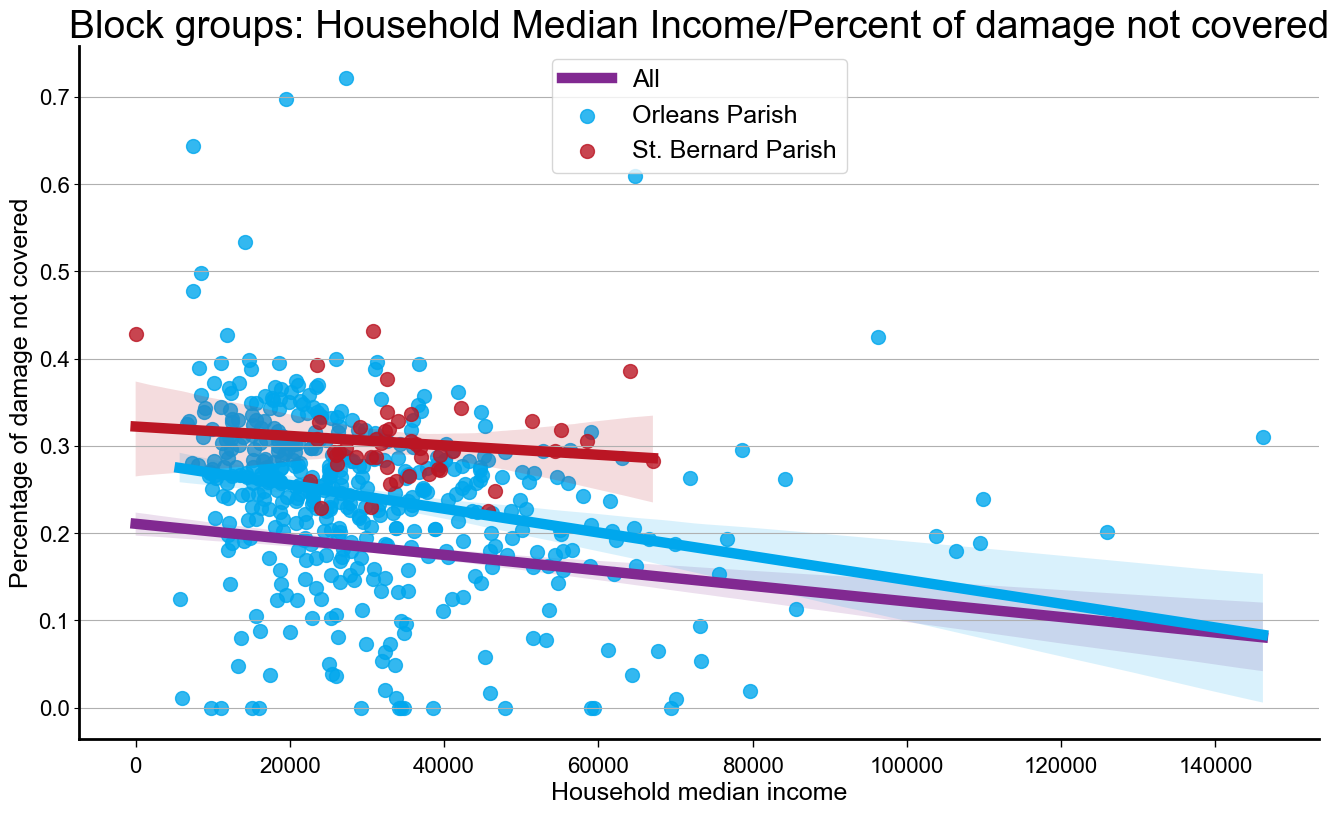

In [25]:
fig, ax = plt.subplots()

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0)], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C4'}, 
            scatter=False,
            label='All',
            ax=ax
            )


sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22087')], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C1'}, 
            color='C1',
            label='St. Bernard Parish',
            ax=ax
            )
ax.set_xlabel('Household median income')
ax.set_ylabel('Percentage of damage not covered')

plt.title('Block groups: Household Median Income/Percent of damage not covered')
plt.legend(loc='upper center')
plt.show()
plt.close()

The same patterns we observed in earlier versions of the analyis hold true. Statewide and in Orleans, the lower the household median income, the more damage was left uncovered. The new analysis shows St. Bernard as being more flat across income groups, as opposed to earlier analysis which showed the uncovered percentage increasing as incomes rose.

In [26]:
table_maker(rh_bg_all, 'hh_median_income_quint', 'All RH properties by median income quintile')
table_maker(rh_bg_all, 'hh_median_income_bin', 'All RH properties by median income bucket')

All RH properties by median income quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_quint,,,,,,,,,,,
"(-0.001, 21488.0]",0.28,"131,359.25","94,870.17","36,489.08","63,715.38","12,958.00",0.14,433322,0.15,175,0.34
"(21488.0, 28421.0]",0.26,"119,061.75","88,101.01","30,960.74","51,376.11","16,379.00",0.18,514685,0.18,108,0.21
"(28421.0, 34948.0]",0.26,"119,628.59","88,585.70","31,042.89","48,065.75","15,968.00",0.17,566297,0.20,72,0.14
"(34948.0, 44328.0]",0.25,"137,600.49","102,827.68","34,772.81","50,496.53","23,171.00",0.25,628451,0.22,68,0.13
"(44328.0, 146158.0]",0.20,"148,625.61","118,161.25","30,464.35","37,431.95","23,294.00",0.25,655048,0.23,90,0.18


All RH properties by median income bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_bin,,,,,,,,,,,
"(0, 15000]",0.29,"133,559.07","95,222.15","38,336.92","65,388.21","3,150.00",0.03,130617,0.05,71,0.14
"(15000, 30000]",0.26,"122,551.54","90,212.71","32,338.83","54,700.99","29,977.00",0.33,954772,0.34,229,0.45
"(30000, 45000]",0.25,"132,721.32","98,996.72","33,724.60","49,805.26","37,143.00",0.40,1093290,0.39,128,0.25
"(45000, 60000]",0.21,"143,700.40","114,073.09","29,627.31","36,931.70","14,558.00",0.16,394170,0.14,51,0.10
"(60000, 75000]",0.20,"149,820.28","120,022.92","29,797.36","33,958.25","5,353.00",0.06,160376,0.06,20,0.04
"(75000, 200000]",0.19,"186,500.13","150,488.00","36,012.13","38,306.93","1,561.00",0.02,64565,0.02,13,0.03


In New Orleans, properties in block groups where the median income was less than $20,000 a year had 27% of their damage left uncovered. Those living in block groups with a median income above $80,000 had 17% of their damage uncovered. 

NOTE #1: New Orleans income comparison.

In [27]:
# table_maker(rh_bg_all, 'hh_median_income_quint_orleans', 'Orleans RH properties by median income quintile', parishes=['22071'])
table_maker(rh_bg_all, 'hh_median_income_bin', 'Orleans RH properties by median income bucket', parishes=['22071'])

Orleans RH properties by median income bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_bin,,,,,,,,,,,
"(0, 15000]",0.30,"183,246.06","128,747.71","54,498.35","89,998.59","1,955.00",0.06,59462,0.13,71,0.15
"(15000, 30000]",0.27,"178,729.44","130,319.28","48,410.16","79,694.87","12,401.00",0.41,213337,0.46,217,0.47
"(30000, 45000]",0.25,"207,421.05","154,684.09","52,736.96","78,346.31","10,343.00",0.34,119195,0.26,102,0.22
"(45000, 60000]",0.23,"231,980.78","178,708.33","53,272.46","65,500.99","3,622.00",0.12,44484,0.10,45,0.10
"(60000, 75000]",0.23,"261,934.60","202,351.46","59,583.14","66,736.47","1,253.00",0.04,17303,0.04,18,0.04
"(75000, 200000]",0.20,"245,676.54","196,822.41","48,854.13","51,300.54",614.00,0.02,13620,0.03,13,0.03


NOTE #2: What would have happened had the lowest-income residents received compensation at the same rate as the wealthiest.

In [28]:
lowest_income_damage = rh_bg_all[(rh_bg_all['hh_median_income']<=15000) & (rh_bg_all['CNTYIDFP00']=='22071') & (rh_bg_all['compensation_sum']>0)][['damage_sum']].sum().loc['damage_sum']
lowest_income_covered = rh_bg_all[(rh_bg_all['hh_median_income']<=15000) & (rh_bg_all['CNTYIDFP00']=='22071') & (rh_bg_all['compensation_sum']>0)][['grant_insurance_sum']].sum().loc['grant_insurance_sum']
lowest_income_grants = rh_bg_all[(rh_bg_all['hh_median_income']<=15000) & (rh_bg_all['CNTYIDFP00']=='22071') & (rh_bg_all['compensation_sum']>0)][['all_grants_count']].sum().loc['all_grants_count']
lowest_income_covered_at_highest_rate = lowest_income_damage*.80

print(f'Actual lowest income damage: ${lowest_income_damage:,.2f}')
print(f'Actual lowest income covered: ${lowest_income_covered:,.2f}')
print(f'Lowest income covered at highest rate: ${lowest_income_covered_at_highest_rate:,.2f}')
print(f'Difference: ${lowest_income_covered_at_highest_rate-lowest_income_covered:,.2f}')
print(f'Difference per grant household: ${(lowest_income_covered_at_highest_rate-lowest_income_covered)/lowest_income_grants:,.2f}')

Actual lowest income damage: $358,246,051.65
Actual lowest income covered: $251,701,770.95
Lowest income covered at highest rate: $286,596,841.32
Difference: $34,895,070.37
Difference per grant household: $17,849.14


NOTE #3: Percent of New Orleans Properties where damage>PSV by income bin

In [29]:
bg_count_damage_gt_psv = rh_clean[rh_clean['Current Damage Assessment']>rh_clean['Current PSV']].groupby('Block Group').size().rename('damage_gt_psv').reset_index()
rh_bg_all[rh_bg_all['CNTYIDFP00']=='22071'].merge(bg_count_damage_gt_psv, left_on='GEOID', right_on='Block Group', how='left').groupby('hh_median_income_bin').agg({'damage_gt_psv' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_gt_psv']/x['all_grants_count'], axis=1).rename('Percent of New Orleans properties where damage>PSV by income bin')

hh_median_income_bin
(0, 15000]        0.70
(15000, 30000]    0.70
(30000, 45000]    0.74
(45000, 60000]    0.52
(60000, 75000]    0.45
(75000, 200000]   0.18
Name: Percent of New Orleans properties where damage>PSV by income bin, dtype: float64

NOTE #4: Shortfall

In [30]:
print('Top 10 neighborhoods by amount of damage not covered')
rh_neighborhoods[['NBHD', 'uncovered_sum']].sort_values(by='uncovered_sum', ascending=False).head(10)

Top 10 neighborhoods by amount of damage not covered


,NBHD,uncovered_sum
39,Little Woods,"242,900,665.43"
54,Read Blvd East,"74,639,233.64"
26,Gentilly Terrace,"66,856,749.24"
19,Fillmore,"66,478,261.85"
36,Lakeview Neighborhood,"66,313,502.67"
41,Lower Ninth Ward Neighborhood,"62,203,107.79"
69,Village de l'est,"59,097,654.17"
56,Seventh Ward,"51,503,226.96"
55,Read Blvd West,"49,428,445.95"
60,St. Roch,"49,413,357.56"


NOTE #5: Lakeview/Pontchartrain Park/Gentilly Woods comparison

In [31]:
rh_neighborhoods[rh_neighborhoods['NBHD'].isin(['Lakeview Neighborhood', 'Pontchartrain Park', 'Gentilly Woods'])][['NBHD', 'pre_storm_value_mean', 'damage_mean', 'uncovered_percent']]

,NBHD,pre_storm_value_mean,damage_mean,uncovered_percent
27,Gentilly Woods,"120,675.56","202,528.20",0.27
36,Lakeview Neighborhood,"326,346.36","285,750.20",0.17
53,Pontchartrain Park,"127,945.44","215,639.36",0.30


NOTE #6: CG/ACG COMPARISON

In [32]:
print('Not White majority')
display(rh_bg_all[(rh_bg_all['white_percent']<.5) & (rh_bg_all['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'cg_uncovered_sum' : 'sum', 'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x/x['damage_sum'], axis=1).rename(columns = {'cg_uncovered_sum' : 'uncovered percent (no acg)', 'uncovered_sum' : 'uncovered_percent (with acg)'}))

print('White majority')
display(rh_bg_all[(rh_bg_all['white_percent']>=.5) & (rh_bg_all['CNTYIDFP00']=='22071')].groupby('hh_median_income_bin').agg({'cg_uncovered_sum' : 'sum', 'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x/x['damage_sum'], axis=1).rename(columns = {'cg_uncovered_sum' : 'uncovered percent (no acg)', 'uncovered_sum' : 'uncovered_percent (with acg)'}))

Not White majority


,uncovered percent (no acg),uncovered_percent (with acg),damage_sum
hh_median_income_bin,,,
"(0, 15000]",0.49,0.30,1.00
"(15000, 30000]",0.45,0.27,1.00
"(30000, 45000]",0.40,0.26,1.00
"(45000, 60000]",0.37,0.28,1.00
"(60000, 75000]",0.30,0.26,1.00
"(75000, 200000]",NaN,NaN,NaN


White majority


,uncovered percent (no acg),uncovered_percent (with acg),damage_sum
hh_median_income_bin,,,
"(0, 15000]",0.24,0.14,1.00
"(15000, 30000]",0.23,0.18,1.00
"(30000, 45000]",0.26,0.22,1.00
"(45000, 60000]",0.20,0.18,1.00
"(60000, 75000]",0.21,0.20,1.00
"(75000, 200000]",0.21,0.20,1.00


In [33]:
rh_neighborhoods[['NBHD', 'uncovered_mean', 'uncovered_percent']]

,NBHD,uncovered_mean,uncovered_percent
0,None,NaN,NaN
1,Algiers Point,"23,617.03",0.22
2,Audubon,"28,072.50",0.17
3,B.W. Cooper,"71,201.34",0.38
4,Bayou St. John,"31,977.63",0.21
5,Behrman,"13,805.35",0.23
6,Black Pearl,"20,271.64",0.24
7,Broadmoor,"54,279.32",0.24
8,Bywater Neighborhood,"37,418.04",0.25
9,Central Business District,"1,799.87",0.02


In [40]:
rh['Closing Option'].value_counts()

1.00    119156
2.00      8507
3.00      2390
Name: Closing Option, dtype: int64

NOTE #7: St. Bernard and buyouts

In [34]:
print('Percent of Road Home recipients who took buyouts')
pd.concat([rh[rh['Closing Option']!=1].groupby('PARISH').size().rename('Buyouts'), rh.groupby('PARISH').size().rename("All Grants")], axis=1).apply(lambda x: x['Buyouts']/x['All Grants'], axis=1).sort_values(ascending=False)

Percent of Road Home recipients who took buyouts


PARISH
St. Bernard            0.37
Orleans                0.11
Plaquemines            0.09
Cameron                0.08
East Feliciana         0.04
St. Landry             0.04
Vermilion              0.03
St. Martin             0.03
Allen                  0.02
Terrebonne             0.02
Iberville              0.02
Lafayette              0.02
St. Tammany            0.02
Iberia                 0.02
Livingston             0.01
Jefferson Davis        0.01
Vernon                 0.01
East Baton Rouge       0.01
Beauregard             0.01
Washington             0.01
Calcasieu              0.01
Lafourche              0.01
Acadia                 0.01
Jefferson              0.01
St. Helena             0.01
St. Mary               0.00
Tangipahoa             0.00
St. Charles            0.00
Ascension               NaN
Assumption              NaN
Evangeline              NaN
Pointe Coupee           NaN
Sabine                  NaN
St. James               NaN
St. John the Baptist    NaN
West Baton Ro

In [35]:
print(f"Statewide buyout percentage: {len(rh[rh['Closing Option']!=1])/len(rh):.1%}")

Statewide buyout percentage: 8.4%


NOTE #8: Percentage of properties where damage exceeded PSV

In [36]:
pd.concat([rh[rh['Current Damage Assessment']>rh['Current PSV']].groupby('PARISH').size(), rh.groupby('PARISH').size()], axis=1).apply(lambda x: x[0]/x[1], axis=1).sort_values(ascending=False)

PARISH
St. Bernard            0.92
Plaquemines            0.83
Cameron                0.76
St. Helena             0.73
St. Mary               0.72
Sabine                 0.71
Pointe Coupee          0.71
Assumption             0.67
Orleans                0.66
Iberville              0.65
Tangipahoa             0.65
Iberia                 0.64
Livingston             0.63
Terrebonne             0.57
Vermilion              0.55
Ascension              0.54
Lafourche              0.54
West Baton Rouge       0.54
St. James              0.53
St. Landry             0.51
West Feliciana         0.50
East Feliciana         0.50
St. Martin             0.50
Evangeline             0.49
Beauregard             0.48
Lafayette              0.46
Allen                  0.44
Vernon                 0.44
Acadia                 0.43
Washington             0.42
St. Tammany            0.41
Jefferson Davis        0.39
Calcasieu              0.34
East Baton Rouge       0.29
St. Charles            0.28
St. John the 

NOTE #9: Pre-storm value/damage and buyout options

In [37]:
print(f"Percentage of people who took a buyout who had more damage than PSV: {len(rh[(rh['Closing Option']!=1) & (rh['Current Damage Assessment']>rh['Current PSV']) & (rh['PARISH']=='St. Bernard')])/len(rh[(rh['Closing Option']!=1) & (rh['PARISH']=='St. Bernard')]):.1%}")

Percentage of people who took a buyout who had more damage than PSV: 97.3%


In [38]:
print(f"Percentage of people who DID NOT take a buyout who had more damage than PSV: {len(rh[(rh['Closing Option']==1) & (rh['Current Damage Assessment']>rh['Current PSV']) & (rh['PARISH']=='St. Bernard')])/len(rh[(rh['Closing Option']==1) & (rh['PARISH']=='St. Bernard')]):.1%}")

Percentage of people who DID NOT take a buyout who had more damage than PSV: 89.6%
